In [13]:
import csv
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from datetime import datetime
from breakout import detect_breakout
import os
import matplotlib.dates as mdate
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

In [2]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
robjects.r("install.packages('changepoint', lib = '/usr/local/lib/R/site-library')")
robseg = importr('robseg')
robjects.r.source("robust-fpop/Simulation.R");

R[write to console]: Warning in install.packages("changepoint", lib = "/usr/local/lib/R/site-library") :
R[write to console]: 
 
R[write to console]:  'lib = "/usr/local/lib/R/site-library"' is not writable



Would you like to use a personal library instead? (yes/No/cancel) yes
--- Please select a CRAN mirror for use in this session ---
Secure CRAN mirrors 

 1: 0-Cloud [https]
 2: Australia (Canberra) [https]
 3: Australia (Melbourne 1) [https]
 4: Australia (Melbourne 2) [https]
 5: Australia (Perth) [https]
 6: Austria [https]
 7: Belgium (Ghent) [https]
 8: Brazil (BA) [https]
 9: Brazil (PR) [https]
10: Brazil (RJ) [https]
11: Brazil (SP 1) [https]
12: Brazil (SP 2) [https]
13: Bulgaria [https]
14: Canada (MB) [https]
15: Chile (Santiago) [https]
16: China (Beijing 2) [https]
17: China (Hefei) [https]
18: China (Hong Kong) [https]
19: China (Guangzhou) [https]
20: China (Lanzhou) [https]
21: China (Nanjing) [https]
22: China (Shanghai 1) [https]
23: China (Shanghai 2) [https]
24: Costa Rica [https]
25: Denmark [https]
26: East Asia [https]
27: Ecuador (Cuenca) [https]
28: Ecuador (Quito) [https]
29: Estonia [https]
30: France (Lyon 1) [https]
31: France (Lyon 2) [https]
32: France (Mar

R[write to console]: trying URL 'https://cran.mirror.garr.it/CRAN/src/contrib/changepoint_2.2.2.tar.gz'

R[write to console]: Content type 'application/octet-stream'
R[write to console]:  length 250737 bytes (244 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


In [3]:
data = {}

data["CPU"] = pd.DataFrame()

source_dir = './CPU'
for f in os.listdir(source_dir):
    f_df = pd.read_csv("%s/%s" % (source_dir, f))
    hw_type, testname = f.split("-")
    f_df["hw_type"] = hw_type
    f_df["testname"] = testname
    data["CPU"] = pd.concat([data["CPU"], f_df])
print (data["CPU"].hw_type.value_counts())

d430      391104
c220g5    378288
m510      212908
c8220     180368
c6320     156456
xl170     151776
m400      150773
c220g1    119880
c6220      97928
r320       60622
c6420      58872
Name: hw_type, dtype: int64


In [4]:
# data["Memory"] = pd.DataFrame()
# source_dir = './memory'
# for f in os.listdir(source_dir):
#     f_df = pd.read_csv("%s/%s" % (source_dir, f))
#     hw_type, testname = f.split("-")
#     f_df["hw_type"] = hw_type
#     f_df["testname"] = testname
#     data["Memory"] = pd.concat([data["Memory"], f_df])
# print (data["Memory"].hw_type.value_counts())

In [5]:
# data["Disk"] = pd.DataFrame()
# source_dir = './disk'
# for f in os.listdir(source_dir):
#     f_df = pd.read_csv("%s/%s" % (source_dir, f))
#     hw_type, testname = f.split("-")
#     f_df["hw_type"] = hw_type
#     f_df["testname"] = testname
#     data["Disk"] = pd.concat([data["Disk"], f_df])
# print (data["Disk"].hw_type.value_counts())

In [16]:
# data["CPU"]

In [7]:
# data["Disk"]

In [8]:
# data["Memory"]

In [9]:
cpu = data["CPU"]
# cpu = cpu[cpu.hw_type=='c6220']
cpu = cpu[cpu.hw_type=='xl170']
cpu = cpu[
        (cpu.dvfs=='yes')&
        (cpu.testname=='MG')&
        (cpu.socket_num==0)&
        (cpu.total_threads==20)
].sort_values("timestamp")
# cpu = cpu[
#         (cpu.dvfs=='yes')&
#         (cpu.testname=='BT')&
#         (cpu.socket_num==0)
#         (cpu.total_threads==28)
# ].sort_values("timestamp")
exec_time = list(cpu['exec_time'].values)
timestamp = cpu.timestamp.values

In [15]:
# cpu

In [11]:
cpu_cpd = cpu['exec_time'].values
cpu_str = ",".join([str(el) for el in cpu_cpd])
robjects.r("cpu_str <- c(%s)" % (cpu_str));

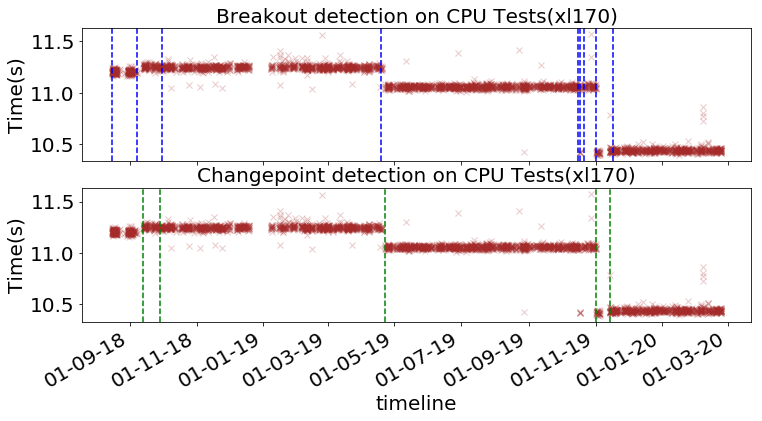

In [14]:
fig,ax = plt.subplots(nrows=2,ncols=1,sharex=True,sharey=False,figsize=(12,6))
secs = mdate.epoch2num(timestamp)

breakout = detect_breakout(exec_time,min_size=10, method='multi', degree=1, beta=0.0001)
breakout_index = [0]+breakout+[len(exec_time)]
ax1 = ax[0]
ax2 = ax[1]
ax1.plot_date(x=secs, y=exec_time, alpha=0.25, marker='x', c='brown')
ax2.plot_date(x=secs, y=exec_time, alpha=0.25, marker='x', c='brown')
mean_vals=[]
percent_change=[]

for i in range(len(breakout_index)-1):
    mean_vals.append(np.mean(exec_time[breakout_index[i]:breakout_index[i+1]]))

for v in breakout_index[:-1]:
    ax1.axvline(x=secs[v], linestyle='--', c='blue')

res=robjects.r("""
est.sd_node <- varDiff(cpu_str)
res.ou_node <- fpop_intern(cpu_str/est.sd_node,  test.stat="Outlier", pen.value=2*log(length(cpu_str)), lthreshold=2.5)
cpt_cpu_node <- res.ou_node$cpts[-length(res.ou_node$cpts)]
""")

for v in robjects.r("cpt_cpu_node"):
    ax2.axvline(x=secs[v], linestyle='--', c='green')


ax1.set_title("Breakout detection on CPU Tests(xl170)",fontsize=20)
ax2.set_title("Changepoint detection on CPU Tests(xl170)",fontsize=20)
plt.xticks(rotation=45, ha='right')
ax1.set_ylabel('Time(s)',fontsize=20)
ax1.tick_params(axis='y', labelsize=20)

for ax in [ax2]:
    date_fmt = '%d-%m-%y'
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.xlabel('timeline',fontsize=20)
    plt.ylabel('Time(s)',fontsize=20)
    date_formatter = mdate.DateFormatter(date_fmt)
    ax.xaxis.set_major_formatter(date_formatter)
    fig.autofmt_xdate()